# 如何構建知識圖譜

在本指南中，我們將介紹如何根據非結構化文本構建知識圖譜的基本方法。構建完成的圖譜可用作 RAG 應用程式中的知識庫。

## ⚠️ 安全提醒 ⚠️

構建知識圖譜需要對資料庫進行寫入操作。這其中存在一定的風險。在導入資料前，請務必進行資料驗證和確認。關於一般的安全最佳實踐，請參閱[這裡](/docs/security)。

## 架構

從高層次來看，從文本構建知識圖譜的步驟如下：

1. **從文本中提取結構化資訊**：使用模型從文本中提取結構化的圖譜資訊。
2. **存儲到圖形資料庫中**：將提取出的結構化圖譜資訊存儲到圖形資料庫中，以便後續的 RAG 應用使用。

## 設置

首先，取得所需的套件並設置環境變數。
在此範例中，我們將使用 Neo4j 圖形資料庫。

In [ ]:
# ! pip3 install --upgrade langchain langchain-community langchain-openai langchain-experimental neo4j

We default to OpenAI models in this guide.

In [2]:
import getpass
import os

# os.environ["OPENAI_API_KEY"] = getpass.getpass()

# Uncomment the below to use LangSmith. Not required.
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

 ········


Next, we need to define Neo4j credentials and connection.
Follow [these installation steps](https://neo4j.com/docs/operations-manual/current/installation/) to set up a Neo4j database.

In [1]:
import os

from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "2wsx3edc"

graph = Neo4jGraph()

In [7]:
graph.query('MATCH (n) DETACH DELETE n;')

[]

## LLM 圖譜轉換器

從文本中提取圖譜數據，可以將非結構化的信息轉換為結構化格式，從而促進更深入的洞察，以及更有效地導航複雜的關係和模式。`LLMGraphTransformer` 通過利用大型語言模型（LLM）來解析並分類實體及其關係，將文本文件轉換為結構化的圖譜文件。LLM 模型的選擇在很大程度上影響輸出的結果，因為它決定了所提取圖譜數據的準確性和細膩度。

In [2]:
import os

from langchain_experimental.graph_transformers import LLMGraphTransformer
# from langchain_openai import ChatOpenAI
from langchain_openai import AzureChatOpenAI


In [8]:

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

llm_transformer = LLMGraphTransformer(llm=llm)

現在我們可以傳入範例文本並檢查結果。

In [9]:
from langchain_core.documents import Document

# text = """
# Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
# She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
# Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
# She was, in 1906, the first woman to become a professor at the University of Paris.
# """
# documents = [Document(page_content=text)]

from langchain_community.document_loaders import PyPDFLoader
documents = []
dir = '../data'
for filename in os.listdir(dir):
    docs = []
    if filename.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(dir, filename))
        documents += loader.load()
    break # too much time, only load one file
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='台灣人壽', type='Company'), Node(id='保險商品', type='Product'), Node(id='增值回饋分享金', type='Benefit'), Node(id='要保人', type='Person'), Node(id='被保險人', type='Person'), Node(id='保單年度', type='Time_period'), Node(id='保險年齡', type='Attribute'), Node(id='現金給付', type='Benefit'), Node(id='儲存生息', type='Benefit'), Node(id='身故保險金', type='Benefit'), Node(id='喪葬費用保險金', type='Benefit')]
Relationships:[Relationship(source=Node(id='台灣人壽', type='Company'), target=Node(id='保險商品', type='Product'), type='PROVIDES'), Relationship(source=Node(id='保險商品', type='Product'), target=Node(id='增值回饋分享金', type='Benefit'), type='INCLUDES'), Relationship(source=Node(id='增值回饋分享金', type='Benefit'), target=Node(id='要保人', type='Person'), type='BENEFICIARY'), Relationship(source=Node(id='增值回饋分享金', type='Benefit'), target=Node(id='被保險人', type='Person'), type='CONDITIONED_ON'), Relationship(source=Node(id='增值回饋分享金', type='Benefit'), target=Node(id='保單年度', type='Time_period'), type='APPLICABLE_AFTER'), Relationship(source=

In [5]:
node_types = set()
relationships = set()
for doc in graph_documents:
    for node in doc.nodes:
        node_types.add(node.type)
    for relationship in doc.relationships:
        relationships.add(relationship.type)
print(f"Types:{node_types}")
print(f"Relationships:{relationships}")
    

Types:{'Law', 'Document', 'Age', 'Insurance', 'Contract clause', 'Organization', 'Person', 'Date', 'Financial_product', 'Financial concept'}
Relationships:{'DEFINE', 'USES', 'RECEIVES', 'INSURE', 'BASED_ON', 'REACHES', 'REFUND', 'AGE_LIMIT', 'PROVIDES', 'CHOOSES', 'BASE_RATE', 'COVERS', 'LIMIT', 'PAYS'}


請參考以下圖片，以更好地了解生成的知識圖譜的結構。

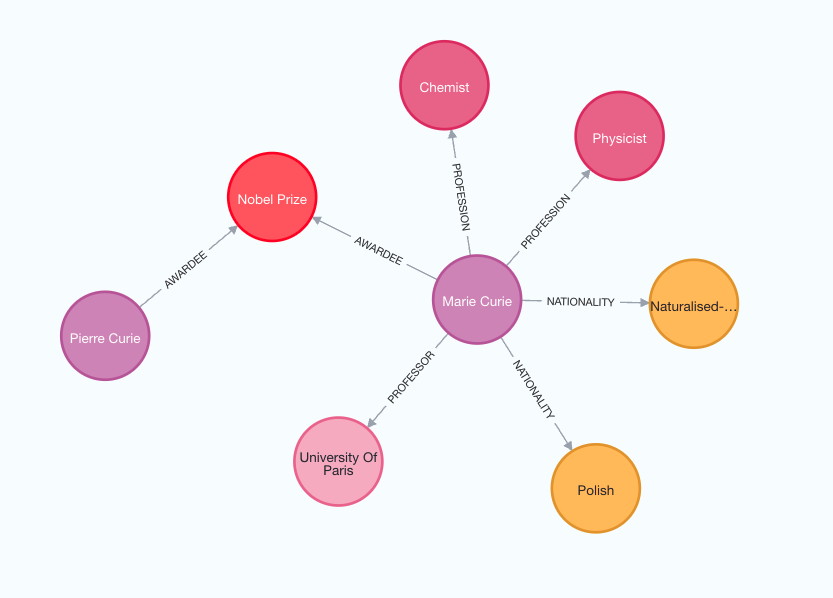

請注意，由於我們使用的是大型語言模型（LLM），圖譜構建過程具有非確定性，因此每次執行時，結果可能會略有不同。

此外，您可以根據需求靈活定義要提取的特定類型的節點和關係。

In [10]:
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["文件", "年齡", "保險", "條款", "個人", "產品", "概念"],
    allowed_relationships = ['定義', '投保', '達到', '賠償', '年齡限制', '提供', '選擇', '基本費率', '涵蓋', '限制']
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)
print(f"Nodes:{graph_documents_filtered[0].nodes}")
print(f"Relationships:{graph_documents_filtered[0].relationships}")

KeyboardInterrupt: 

為了更好地理解生成的圖譜，我們可以再次將其視覺化。

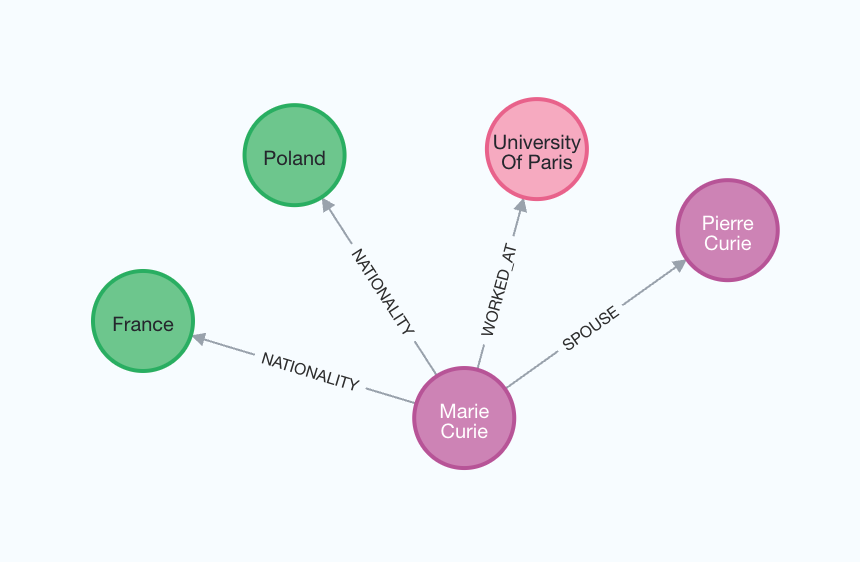

`node_properties` 參數允許提取節點屬性，從而創建更詳細的圖譜。
當設置為 `True` 時，LLM 會自動識別並提取相關的節點屬性。
相反，如果 `node_properties` 定義為字符串列表，LLM 只會選擇性地從文本中檢索指定的屬性。

In [7]:
llm_transformer_props = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization"],
    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
    node_properties=["born_year"],
)
graph_documents_props = llm_transformer_props.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents_props[0].nodes}")
print(f"Relationships:{graph_documents_props[0].relationships}")

Nodes:[Node(id='Marie Curie', type='Person', properties={'born_year': '1867'}), Node(id='Pierre Curie', type='Person'), Node(id='University Of Paris', type='Organization')]
Relationships:[Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Pierre Curie', type='Person'), type='SPOUSE'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='University Of Paris', type='Organization'), type='WORKED_AT')]


## 存儲到圖形資料庫

生成的圖譜文件可以使用 `add_graph_documents` 方法存儲到圖形資料庫中。

In [11]:
graph.add_graph_documents(graph_documents) # graph_documents, graph_documents_filtered, graph_documents_props